In [1]:
from __future__ import print_function
%matplotlib inline  

import numpy as np
import keras
import cPickle
import matplotlib.pyplot as plt


/home/ihradis/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
Using gpu device 0: GeForce GTX 780 (CNMeM is disabled, cuDNN 4007)


In [2]:
def collage(data):
    images = [img for img in data.transpose(0, 2, 3, 1)]
    side = int(np.ceil(len(images)**0.5))
    for i in range(side**2 - len(images)):
        images.append(images[-1])
    collage = [np.concatenate(images[i::side], axis=0)
               for i in range(side)]
    collage = np.concatenate(collage, axis=1)
    #collage -= collage.min()
    #collage = collage / np.absolute(collage).max() * 256
    return collage
    

## Read data from CIFAR 10
Download the data using wget 

Trn data shape: (57418, 1, 48, 48)
Tst data shape: (14356, 1, 48, 48)


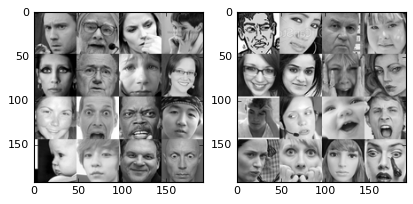

Trn labels shape:  (57418, 7)
Tst labels shape:  (14356, 7)
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.]]


In [3]:
data = np.load('./fer2013/fer2013.npz')
trnData = data['trnData'].reshape(-1,1,48,48)
trnLabels = data['trnLabels']
tstData = data['valData'].reshape(-1,1,48,48)
tstLabels = data['valLabels']

trnData = np.concatenate([trnData[:,:,:,::-1], trnData])
trnLabels = np.concatenate([trnLabels, trnLabels])
tstData = np.concatenate([tstData[:,:,:,::-1], tstData])
tstLabels = np.concatenate([tstLabels, tstLabels])

print('Trn data shape:', trnData.shape)
print('Tst data shape:', tstData.shape)
plt.subplot(1, 2, 1)
img = collage(trnData[:16])
img = np.concatenate([img, img, img], axis=2)
plt.imshow(img)
plt.subplot(1, 2, 2)
img = collage(tstData[:16])
img = np.concatenate([img, img, img], axis=2)
plt.imshow(img)
plt.show()

from sklearn.preprocessing import OneHotEncoder

trnLabels = OneHotEncoder(sparse=False, dtype=np.float32).fit_transform(trnLabels.reshape(-1,1))
tstLabels = OneHotEncoder(sparse=False, dtype=np.float32).fit_transform(tstLabels.reshape(-1,1))

print('Trn labels shape: ', trnLabels.shape)
print('Tst labels shape: ', tstLabels.shape)
print(trnLabels[:5,:])
print(tstLabels[:5,:])

## Normalize data

In [4]:
trnData = trnData.astype(np.float32) 
trnData = (trnData - np.mean(trnData, axis=(2,3), keepdims=True)) / (np.std(trnData, axis=(2,3), keepdims=True) + 5) / 2.0
tstData = tstData.astype(np.float32)
tstData = (tstData - np.mean(tstData, axis=(2,3), keepdims=True)) / (np.std(tstData, axis=(2,3), keepdims=True) + 5) / 2.0
'''def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return ZCAMatrix
np.dot(ZCAMatrix, inputs)
'''


'def zca_whitening(inputs):\n    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix\n    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition\n    epsilon = 0.1                #Whitening constant, it prevents division by zero\n    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix\n    return ZCAMatrix\nnp.dot(ZCAMatrix, inputs)\n'

## Create network + compilemodel

In [5]:
def C_BN_RELU(net, k_count, size, name=None, border='valid'):
    from keras.layers import Convolution2D, BatchNormalization, Activation
   
    net = Convolution2D(k_count, size, size, name=name,
            init='glorot_uniform',
            border_mode=border, 
            dim_ordering='th')(net)
    net = BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, 
            weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, 
            beta_regularizer=None)(net)
    net = Activation('relu')(net)
    return net

    
def CNN_L4(in_dim):
    from keras.layers import Input, Convolution2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten
    from keras.layers import BatchNormalization, Activation
    input_data = Input(shape=(in_dim), name='data')

    net = C_BN_RELU(input_data, 32, 5, name='conv1', border='valid')  
    net = C_BN_RELU(net, 64, 3, name='conv2', border='valid')  
    net = Dropout(0.4)(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)
    net = C_BN_RELU(net, 128, 3, name='conv3', border='same')  
    net = C_BN_RELU(net, 128, 3, name='conv4', border='same')  
    net = Dropout(0.4)(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool4',
            border_mode='same', dim_ordering='th')(net)
    net = C_BN_RELU(net, 256, 3, name='conv5', border='same')  
    net = C_BN_RELU(net, 256, 3, name='conv6', border='same')  
    net = Dropout(0.4)(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)
    net = Flatten()(net)
    net = Dense(256, name='fc7', activation='relu')(net)
    net = Dropout(0.5, name='drop7')(net)
    net = Dense(256, name='fc8', activation='relu')(net)
    net = Dropout(0.5, name='drop8')(net)
    net = Dense(10, name='fc9', activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model

def CNN_L9(in_dim):
    from keras.layers import Input, Convolution2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten
    from keras.layers import BatchNormalization, Activation
    input_data = Input(shape=(in_dim), name='data')

    net = conv(32, 5, name='conv1', border='valid')(input_data)
    net = conv(32, 3, name='conv2', border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)
    net = conv(64, 3, name='conv3', border='same')(net)
    net = conv(64, 3, name='conv4', border='same')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool4',
            border_mode='same', dim_ordering='th')(net)
    net = conv(128, 3, name='conv5', border='same')(net)
    net = conv(128, 3, name='conv6', border='same')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)
    
    net = Flatten()(net)
    net = Dense(256, name='fc7', activation='relu')(net)
    net = Dropout(0.5, name='drop7')(net)
    net = Dense(256, name='fc8', activation='relu')(net)
    net = Dropout(0.5, name='drop8')(net)
    net = Dense(10, name='fc9', activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model

In [6]:
def recursiveCNN(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten
    recLayer32 = conv(32, 3, name='r32')
    recLayer64 = conv(64, 3, name='r64')
    recLayer128 = conv(128, 3, name='r128')
    recLayer256 = conv(256, 3, name='r256',border='valid')
    dense128 = Dense(128, name='fc', activation='relu')
    dense256 = Dense(256, name='fc', activation='relu')

    input_data = Input(shape=(in_dim), name='data')

    net = conv(32, 5, name='conv1', border='valid')(input_data)
    net = conv(64, 3, name='conv2', border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)    
    
    net = recLayer64(net)
    net = recLayer64(net)
    net = recLayer64(net)
    net = conv(128, 3, name='conv5', border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)    
    
    net = recLayer128(net)
    net = recLayer128(net)
    net = recLayer128(net)
    
    net = keras.layers.local.LocallyConnected2D(
        128, 3, 3, activation='relu', border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    net = keras.layers.local.LocallyConnected2D(
        128, 3, 3, activation='relu', border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    
    net = Flatten()(net)
    net = Dense(10, name='fc9', activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model    
    
    

In [100]:
from keras.regularizers import l2

w_decay = 0.0005
w_reg = l2(w_decay)
from keras.constraints import unitnorm

def conv(count, size, name=None, border='same'):
    from keras.layers import Convolution2D
    layer = Convolution2D(count, size, size, name=name,
        init='glorot_uniform',
        border_mode=border, 
        activation='relu',
        W_constraint = unitnorm()
        W_regularizer=w_reg,
                          
        dim_ordering='th')
    return layer

def recursiveCNN_2(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten
    recLayer32 = conv(32, 3, name='r32')
    recLayer64 = conv(64, 3, name='r64')
    recLayer128 = conv(128, 3, name='r128')
    recLayer256 = conv(256, 3, name='r256',border='valid')
    dense128 = Dense(128, name='fc', activation='relu')
    dense256 = Dense(256, name='fc', activation='relu')

    input_data = Input(shape=(in_dim), name='data')

    net = conv(32, 5, border='valid')(input_data)
    net = conv(32, 3, border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool2',
            border_mode='same', dim_ordering='th')(net)    
    
    net = conv(48, 3, border='same')(net)
    net = conv(48, 3, border='same')(net)
    net = MaxPooling2D((2,2), strides=(2,2), name='pool6',
            border_mode='same', dim_ordering='th')(net)    
    net = conv(64, 3, border='same')(net)
    net = keras.layers.local.LocallyConnected2D(
        32, 3, 3, activation='relu', W_regularizer=w_reg, border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    net = keras.layers.local.LocallyConnected2D(
        32, 3, 3, activation='relu', W_regularizer=w_reg, border_mode='valid')(net)    
    net = Dropout(0.5)(net)
    
    net = Flatten()(net)
    net = Dense(10, name='fc9', W_regularizer=l2(0.000001), activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model    

SyntaxError: invalid syntax (<ipython-input-100-a879f537fbac>, line 14)

In [101]:
# models from STRIVING FOR SIMPLICITY:THE ALL CONVOLUTIONAL NET

def CIFAR_A(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D, Activation
    input_data = Input(shape=(in_dim), name='data')
    net = Dropout(0.2)(input_data)
    net = conv(96, 5, border='valid')(input_data)
    net = MaxPooling2D((3,3), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    net = Dropout(0.5)(net)
    net = conv(192, 5, border='valid')(net)
    net = MaxPooling2D((3,3), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    net = Dropout(0.5)(net)
    net = conv(192, 5, border='same')(net)
    net = conv(192, 1, border='same')(net)
    net = conv(7, 1, border='same')(net)
    net = AveragePooling2D ((8,8), strides=(8,8), 
            border_mode='valid', dim_ordering='th')(net)
    net = Flatten()(net)
    net = Activation('softmax')(net)    
    from keras.models import Model
    model = Model(input=[input_data], output=[net])

    return model    

In [102]:
def local_Net(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D, Activation, GlobalAveragePooling2D
    input_data = Input(shape=(in_dim), name='data')
    net = conv(32, 5, border='valid')(input_data)
    net = conv(64, 3, border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    #net = Dropout(0.5)(net)
    net = conv(96, 3, border='valid')(net)
    net = conv(96, 3, border='valid')(net)
    net = MaxPooling2D((2,2), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    #net = Dropout(0.5)(net)
    net = keras.layers.local.LocallyConnected2D(
        64, 3, 3, activation='relu', border_mode='valid')(net)     
    net = keras.layers.local.LocallyConnected2D(
        64, 3, 3, activation='relu', border_mode='valid')(net)     
    net = keras.layers.local.LocallyConnected2D(
        64, 3, 3, activation='relu', border_mode='valid')(net)     
    #net = conv(64, 3, border='valid')(net)
    #net = conv(64, 3, border='valid')(net)
    #net = conv(64, 3, border='valid')(net)
    net = Flatten()(net)
    net = Dense(256, name='fc8', W_regularizer=l2(0.001), activation='relu')(net)
    net = Dense(7, name='fc9', W_regularizer=l2(0.0001), activation='softmax')(net)
    from keras.models import Model
    model = Model(input=[input_data], output=[net])
    return model

In [103]:
def simple_Net(in_dim):
    from keras.layers import Input, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D, Activation, BatchNormalization
    from keras.layers import GlobalAveragePooling2D

    input_data = Input(shape=(in_dim), name='data')
    
    net = C_BN_RELU(input_data, 32, 5, border='valid')
    #net = C_BN_RELU(net, 48, 3, border='valid')
    net = MaxPooling2D((2,2), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)

    net = C_BN_RELU(net, 64, 3, border='valid')
    #net = C_BN_RELU(net, 64, 3, border='valid')
    net = MaxPooling2D((2,2), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    
    net = C_BN_RELU(net, 96, 3, border='same')
    #net = C_BN_RELU(net, 96, 3, border='same')
    net = MaxPooling2D((2,2), strides=(2,2), 
            border_mode='same', dim_ordering='th')(net)    
    net = Dropout(0.5)(net)
    #net = C_BN_RELU(net, 128, 3, border='same')
    net = C_BN_RELU(net, 128, 3, border='valid')
    net = C_BN_RELU(net, 256, 1, border='same')
    net = conv(7, 1, border='valid')(net)
    net = GlobalAveragePooling2D(dim_ordering='th')(net)
    net = Activation('softmax')(net)    


    '''
    net = Flatten()(net)
    
    net = Dense(320, name='fc7', W_regularizer=l2(0.001))(net)
    net = BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, 
            weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, 
            beta_regularizer=None)(net)
    net = Activation('relu')(net)
    
    
    net = Dense(320, name='fc8', W_regularizer=l2(0.001))(net)
    net = BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, 
            weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, 
            beta_regularizer=None)(net)
    net = Activation('relu')(net)
    
    net = Dense(7, name='fc9', W_regularizer=l2(0.0001), activation='softmax')(net)
    '''
    
    from keras.models import Model
    model = Model(input=[input_data], output=[net])
    return model

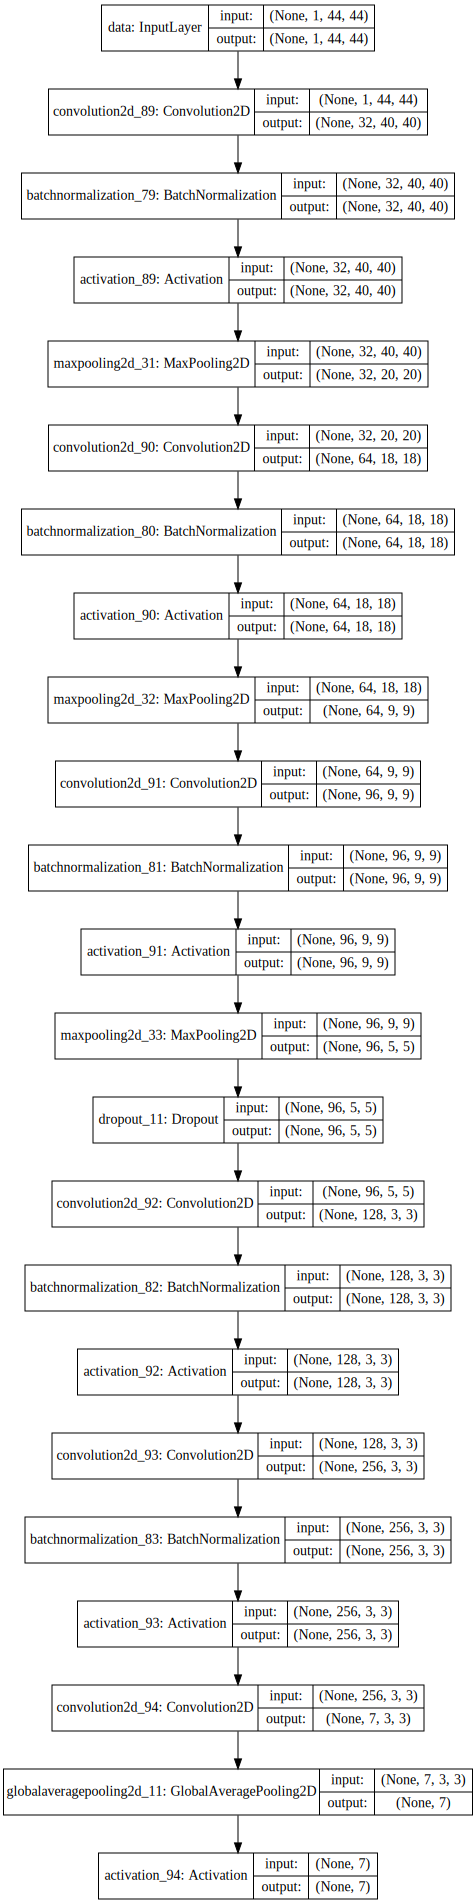

In [104]:
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
dataSize = 44
model = simple_Net((1,dataSize,dataSize))

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# show network
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [105]:
'''from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.15625,
    height_shift_range=0.15625,
    zca_whitening=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    fill_mode='nearest',
    horizontal_flip=True,
    dim_ordering="th")

datagen.fit(trnData)
'''


'from keras.preprocessing.image import ImageDataGenerator\ndatagen = ImageDataGenerator(\n    width_shift_range=0.15625,\n    height_shift_range=0.15625,\n    zca_whitening=True,\n    samplewise_center=True,\n    samplewise_std_normalization=True,\n    fill_mode=\'nearest\',\n    horizontal_flip=True,\n    dim_ordering="th")\n\ndatagen.fit(trnData)\n'

In [106]:
# data generator
from functools import partial
from numpy.random import randint
from numba import jit


@jit
def getData(perm, data, targetSize, border, intensityShift, intesityScale):
    batchData = data[perm]
    batchSize = len(perm)
    
    if border[0]:
        crops = np.zeros((batchSize, data.shape[1], targetSize, targetSize), dtype=np.float32)
        b0 = randint(border[0], size=batchSize)
        b1 = randint(border[1], size=batchSize)
        for i in range(batchSize):
            crops[i] = batchData[i, :, b0[i]:b0[i]+targetSize, b1[i]:b1[i]+targetSize]
        if intensityShift:
            crops += np.random.randn(batchSize, 1, 1, 1) * intensityShift
        if intesityScale:
            crops *= 1 + np.random.randn(batchSize, 1, 1, 1) * intesityScale
        batchData = crops
            
    return batchData


def generator(data, labels, targetSize, batchSize, intensityShift=0, intesityScale=0):
    nb_samples = data.shape[0]
    border = [data.shape[2]-targetSize, data.shape[3]-targetSize]
    while True:
        perm = np.random.permutation(nb_samples)
        for i in range(0, nb_samples-batchSize, batchSize):
            batchPerm = perm[i:i+batchSize]
            batchLabels = labels[batchPerm]
            batchData = getData(batchPerm, data, targetSize, border, intensityShift, intesityScale)
            yield  batchData , batchLabels
    print('out')

    


## Prepare generator and show data from the generator
This generator is more complex - shifts and scales colors

FITTING
-3.41413 4.01394


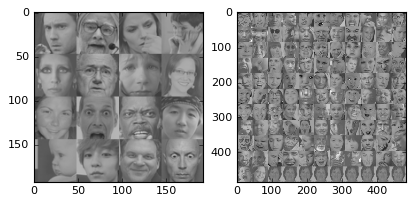

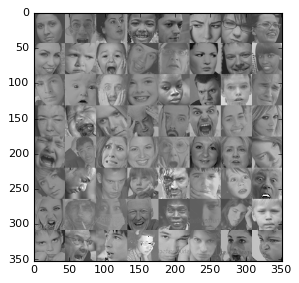

In [107]:
print('FITTING')

border = trnData.shape[2] - dataSize
valData = tstData[:,:,border:border+dataSize, border:border+dataSize]
plt.subplot(1, 2, 1)
print(trnData.min(), trnData.max())
img = collage(trnData[:16]) / 4.0
img = np.concatenate([img, img, img], axis=2)
plt.imshow(img + 0.5)
plt.subplot(1, 2, 2)
img = collage(valData[::128]) / 4.0
img = np.concatenate([img, img, img], axis=2)
plt.imshow(img + 0.5)
plt.show()


import itertools

gen1 = generator(data=trnData, labels=trnLabels, targetSize=dataSize, batchSize=64, intensityShift=0.2, intesityScale=0.2)

    
for batchData in itertools.islice(gen1, 1):
    img = collage(batchData[0]) / 4.0
    img = np.concatenate([img, img, img], axis=2)
    plt.imshow(img + 0.5)
    plt.show()
    

# it(
#    {'data':trnData}, trnLabels,
#    validation_data=(tstData, tstLabels),
#    batch_size=512, nb_epoch=20)



In [111]:
model.optimizer.lr = 0.1
while True:
    print('LEARNING RATE', model.optimizer.lr)
    model.fit_generator(
        generator(data=trnData, labels=trnLabels, targetSize=dataSize, batchSize=64, intensityShift=0.2, intesityScale=0.15), 
        samples_per_epoch = 40000, 
        nb_epoch = 30,  validation_data=(valData, tstLabels), nb_worker=1)
    model.optimizer.lr *= 0.5
print('DONE')

LEARNING RATE 0.1
Epoch 1/30
40000/40000 [==============================] - 29s - loss: 1.6144 - acc: 0.3912 - val_loss: 1.5614 - val_acc: 0.4077
Epoch 2/30
 9088/40000 [=====>........................] - ETA: 20s - loss: 1.5796 - acc: 0.3998

KeyboardInterrupt: 

In [26]:
name = 'conv_net_adadelta'
model_json = model.to_json()
with open("name.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("name.h5")
print("Saved model to disk")

Saved model to disk


(32, 1, 5, 5)


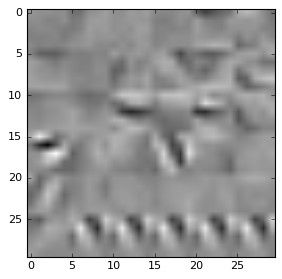

In [112]:
layer = model.layers[1]
print(layer.get_weights()[0].shape)
img = collage(layer.get_weights()[0])
img = img - img.min()
img = img / img.max()
img = np.concatenate([img, img, img], axis=2)
plt.imshow(img)
plt.show()
